<a href="https://colab.research.google.com/github/ganeshk79/Bharat_Intern/blob/main/Titanic_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Task 2 : Titanic Classification
BY GANESH KARIBANDI


#Introduction
In this code, we are working with the Titanic dataset, aiming to predict whether passengers survived or not based on various features. The code includes data exploration, preprocessing, building a machine learning model (Random Forest Classifier), hyperparameter tuning, and making predictions on a test dataset. Let's break down the code step by step.

#Data Loading and Exploration
We start by loading the Titanic dataset, displaying the last few rows, and generating a heatmap to visualize the correlation between different features.

<ipython-input-10-83066001ebb6>:14: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(titanic_data.corr(), cmap='YlGnBu')


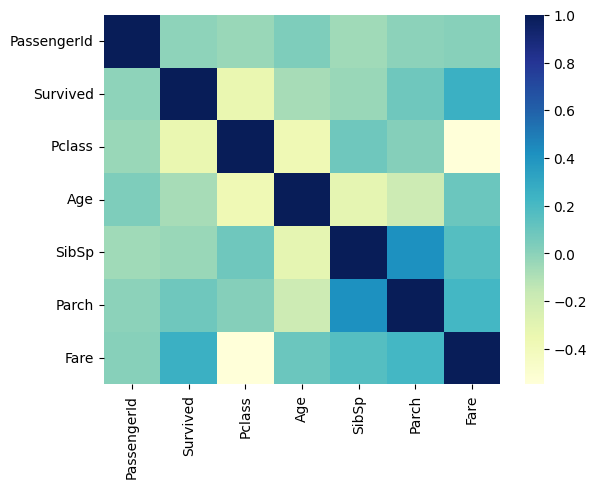

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load Titanic dataset
titanic_data = pd.read_csv("/train.csv")
titanic_data.tail()

# Display summary statistics
titanic_data.describe()

# Visualize correlation using a heatmap
sns.heatmap(titanic_data.corr(), cmap='YlGnBu')
plt.show()

#Data Splitting
We use StratifiedShuffleSplit to split the data into training and testing sets while maintaining the proportion of the target variable (Survived) in both sets.

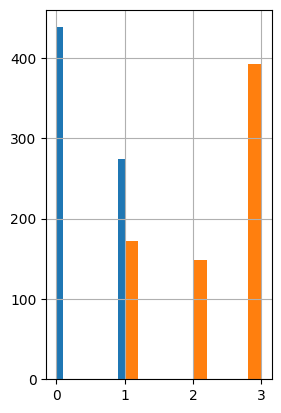

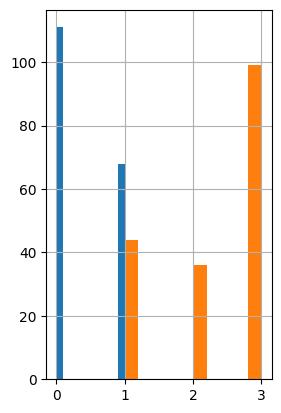

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 403 to 808
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  712 non-null    int64  
 1   Survived     712 non-null    int64  
 2   Pclass       712 non-null    int64  
 3   Name         712 non-null    object 
 4   Sex          712 non-null    object 
 5   Age          573 non-null    float64
 6   SibSp        712 non-null    int64  
 7   Parch        712 non-null    int64  
 8   Ticket       712 non-null    object 
 9   Fare         712 non-null    float64
 10  Cabin        157 non-null    object 
 11  Embarked     710 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 72.3+ KB


None

In [12]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2)
for train_indices, test_indices in split.split(titanic_data, titanic_data[["Survived", "Pclass", "Sex"]]):
    strat_train_set = titanic_data.loc[train_indices]
    strat_test_set = titanic_data.loc[test_indices]

# Display histograms of features in the training set
plt.subplot(1, 2, 1)
strat_train_set["Survived"].hist()
strat_train_set["Pclass"].hist()
plt.show()

# Display histograms of features in the testing set
plt.subplot(1, 2, 2)
strat_test_set["Survived"].hist()
strat_test_set["Pclass"].hist()
plt.show()

# Display information about the training set
display(strat_train_set.info())

#Data Preprocessing with Custom Transformers
We define custom transformers using scikit-learn's BaseEstimator and TransformerMixin to handle missing values and encode categorical features.

In [13]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

class AgeImputer(BaseEstimator, TransformerMixin):
    # Custom transformer to impute missing values in the "Age" column with the mean
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        imputer = SimpleImputer(strategy="mean")
        X["Age"] = imputer.fit_transform(X[["Age"]])
        return X

class FeatureEncoder(BaseEstimator, TransformerMixin):
    # Custom transformer to one-hot encode categorical features "Embarked" and "Sex"
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        encoder = OneHotEncoder()
        matrix = encoder.fit_transform(X[["Embarked"]]).toarray()
        column_names = ["C", "S", "Q", "N"]

        for i in range(len(matrix.T)):
            X[column_names[i]] = matrix.T[i]

        matrix = encoder.fit_transform(X[["Sex"]]).toarray()

        column_names = ["Female", "Male"]
        for i in range(len(matrix.T)):
            X[column_names[i]] = matrix.T[i]

        return X

class FeatureDropper(BaseEstimator, TransformerMixin):
    # Custom transformer to drop unnecessary columns
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.drop(["Embarked", "Name", "Ticket", "Cabin", "Sex", "N"], axis=1, errors="ignore")

# Combine transformers into a pipeline
pipeline = Pipeline([
    ("ageimputer", AgeImputer()),
    ("featureenconder", FeatureEncoder()),
    ("featuredropper", FeatureDropper())
])

# Apply the pipeline to the training set
strat_train_set = pipeline.fit_transform(strat_train_set)

# Display information about the transformed training set
display(strat_train_set.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 403 to 808
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  712 non-null    int64  
 1   Survived     712 non-null    int64  
 2   Pclass       712 non-null    int64  
 3   Age          712 non-null    float64
 4   SibSp        712 non-null    int64  
 5   Parch        712 non-null    int64  
 6   Fare         712 non-null    float64
 7   C            712 non-null    float64
 8   S            712 non-null    float64
 9   Q            712 non-null    float64
 10  Female       712 non-null    float64
 11  Male         712 non-null    float64
dtypes: float64(7), int64(5)
memory usage: 72.3 KB


None

#Data Scaling and Model Building
We scale the features and use a Random Forest Classifier for building the predictive model. Hyperparameter tuning is performed using GridSearchCV.

In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Separate features and target variable
X = strat_train_set.drop(['Survived'], axis=1)
Y = strat_train_set['Survived']

# Scale features
scaler = StandardScaler()
X_data = scaler.fit_transform(X)
Y_data = Y.to_numpy()

# Build a Random Forest Classifier
clf = RandomForestClassifier()

# Define hyperparameter grid for GridSearchCV
param_grid = [{"n_estimators": [10, 100, 200, 500], "max_depth": [None, 5, 10], "min_samples_split": [2, 3, 4]}]

# Perform GridSearchCV
grid_search = GridSearchCV(clf, param_grid, cv=3, scoring="accuracy", return_train_score=True)
display(grid_search.fit(X_data, Y_data))

# Get the best estimator from GridSearchCV
final_clf = grid_search.best_estimator_
display(final_clf)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid=[{'max_depth': [None, 5, 10],
                          'min_samples_split': [2, 3, 4],
                          'n_estimators': [10, 100, 200, 500]}],
             return_train_score=True, scoring='accuracy')

RandomForestClassifier(max_depth=10, min_samples_split=3)

#Model Evaluation on Test Set
We apply the preprocessing pipeline to the test set and evaluate the final model's performance

In [15]:
# Apply the pipeline to the test set
strat_test_set = pipeline.fit_transform(strat_test_set)
display(strat_test_set.tail())

# Separate features and target variable in the test set
X_test = strat_test_set.drop(['Survived'], axis=1)
Y_test = strat_test_set['Survived']

# Scale features in the test set
scaler = StandardScaler()
x_data_test = scaler.fit_transform(X_test)
y_data_test = Y_test.to_numpy()

# Evaluate the final model on the test set
print("Accuracy :",end='')
print(final_clf.score(x_data_test, y_data_test))

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,C,S,Q,Female,Male
15,16,1,2,55.000000,0,0,16.0000,0.0,0.0,1.0,1.0,0.0
110,111,0,1,47.000000,0,0,52.0000,0.0,0.0,1.0,0.0,1.0
389,390,1,2,17.000000,0,0,12.0000,1.0,0.0,0.0,1.0,0.0
124,125,0,1,54.000000,0,1,77.2875,0.0,0.0,1.0,0.0,1.0
303,304,1,2,28.888298,0,0,12.3500,0.0,1.0,0.0,1.0,0.0


Accuracy :0.8100558659217877


from matplotlib import pyplot as plt
_df_32['PassengerId'].plot(kind='hist', bins=20, title='PassengerId')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_33['Survived'].plot(kind='hist', bins=20, title='Survived')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_34['Pclass'].plot(kind='hist', bins=20, title='Pclass')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_35['Age'].plot(kind='hist', bins=20, title='Age')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_36.plot(kind='scatter', x='PassengerId', y='Survived', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_37.plot(kind='scatter', x='Survived', y='Pclass', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_38.plot(kind='scatter', x='Pclass', y='Age', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_39.plot(kind='scatter', x='Age', y='Parch', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['SibSp']
  ys = series['PassengerId']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_40.sort_values('SibSp', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('SibSp')
_ = plt.ylabel('PassengerId')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['SibSp']
  ys = series['Survived']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_41.sort_values('SibSp', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('SibSp')
_ = plt.ylabel('Survived')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['SibSp']
  ys = series['Pclass']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_42.sort_values('SibSp', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('SibSp')
_ = plt.ylabel('Pclass')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['SibSp']
  ys = series['Age']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_43.sort_values('SibSp', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('SibSp')
_ = plt.ylabel('Age')

from matplotlib import pyplot as plt
_df_44['PassengerId'].plot(kind='line', figsize=(8, 4), title='PassengerId')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_45['Survived'].plot(kind='line', figsize=(8, 4), title='Survived')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_46['Pclass'].plot(kind='line', figsize=(8, 4), title='Pclass')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_47['Age'].plot(kind='line', figsize=(8, 4), title='Age')
plt.gca().spines[['top', 'right']].set_visible(False)

#Predictions on the Final Test Set
We preprocess the final test set and make predictions using the tuned Random Forest Classifier.

In [17]:
# Read the final test dataset
titanic_test_data = pd.read_csv('/test.csv')
display(titanic_test_data.head())

# Apply the pipeline to the final test set
final_test_data = pipeline.fit_transform(titanic_test_data)
display(final_test_data.info())

# Fill missing values using forward fill
X_final_test = final_test_data
X_final_test = X_final_test.fillna(method='ffill')

# Scale features in the final test set
scaler = StandardScaler()
X_data_final_test = scaler.fit_transform(X_final_test)

# Make predictions using the final model
predictions = final_clf.predict(X_data_final_test)



,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Age          418 non-null    float64
 3   SibSp        418 non-null    int64  
 4   Parch        418 non-null    int64  
 5   Fare         417 non-null    float64
 6   C            418 non-null    float64
 7   S            418 non-null    float64
 8   Q            418 non-null    float64
 9   Female       418 non-null    float64
 10  Male         418 non-null    float64
dtypes: float64(7), int64(4)
memory usage: 36.0 KB


None

In [18]:
# Create a DataFrame with PassengerId and predicted Survived values
final_df = pd.DataFrame(titanic_test_data['PassengerId'])
final_df['Survived'] = predictions
display(final_df)

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


from matplotlib import pyplot as plt
final_df['PassengerId'].plot(kind='hist', bins=20, title='PassengerId')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
final_df['Survived'].plot(kind='hist', bins=20, title='Survived')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
final_df.plot(kind='scatter', x='PassengerId', y='Survived', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['PassengerId']
  ys = series['Survived']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = final_df.sort_values('PassengerId', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('PassengerId')
_ = plt.ylabel('Survived')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['PassengerId']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'PassengerId'}, axis=1)
              .sort_values('PassengerId', ascending=True))
  xs = counted['PassengerId']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = final_df.sort_values('PassengerId', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('PassengerId')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
final_df['PassengerId'].plot(kind='line', figsize=(8, 4), title='PassengerId')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
final_df['Survived'].plot(kind='line', figsize=(8, 4), title='Survived')
plt.gca().spines[['top', 'right']].set_visible(False)